https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm

In [12]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install -q tensorflow==2.0.0-beta1
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [13]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [14]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]


In [15]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image,steps=2)



TypeError: Image data of dtype object cannot be converted to float

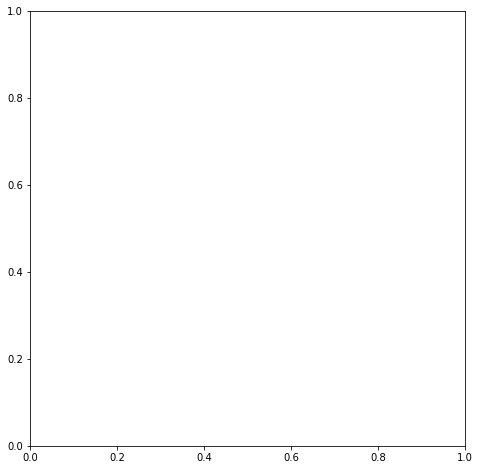

In [16]:
# with tf.Session as sess:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()


In [17]:
#FGSM
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad


In [18]:
perturbations = create_adversarial_pattern(image, image_probs)
plt.imshow(perturbations[0])


ValueError: Cannot reshape a tensor with 2 elements to shape [1] (1 elements) for 'categorical_crossentropy/softmax_cross_entropy_with_logits/Reshape_2' (op: 'Reshape') with input shapes: [2], [1] and with input tensors computed as partial shapes: input[1] = [1].

In [30]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()
    
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])



NameError: name 'perturbations' is not defined